In [1]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import animation, cm
import seaborn as sns
import datetime
from scipy import stats
from scipy import optimize

from pandas_datareader.data import DataReader
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

from statsmodels.tools.numdiff import approx_fprime, approx_hess

from typing import Union, List

"""
Own packages
"""
from codelib.dal.fred_yield_data import get_nominal_yield_data

from codelib.visualization.base import correlation_plot
from codelib.visualization.layout import DefaultStyle
DefaultStyle();

# Exercises - Week 6

In this week we will look at a few exercises involving estimation. 

## Problem 1: Recession forecasting 

__Note:__ We follow the exposition of [Nyberg (2010)](https://onlinelibrary-wiley-com.esc-web.lib.cbs.dk:8443/doi/abs/10.1002/for.1161)

In this exercise, we will explore a simple model for forecasting US recessions. Among other things, we will look at the evidence for the yield spread being a predictor of recessions as often mentioned in financial news (and the academic literature). 

We are interested in prediciting the recession indicator $y_t, \; t=1,..., T$ which is a binary dependent variable that is defined by

$$
y_t = \left\{ \begin{matrix}
                1, & \text{if the economy is in a recessionary state at time } t \\ 
                0, & \text{if the economy is in a expansionary state at time } t
              \end{matrix}  \right.
$$

The probability of the dependent variable taking the value $1$ is given by $p_t$ specified as 

$$
p_t = \text{Prob}_{t-1}[y_t = 1] = \Phi(\pi_{t})
$$

where $\Phi()$ is the cdf of a standard normal. $\pi_{t}$ is included in the information set at time $t-1$. This model is known as a [Probit model](https://en.wikipedia.org/wiki/Probit_model). 

A model not taking the dynamic structure into account is given by the static formulation ($k \leq 1$ must be larger than the forecast horizon) 

$$
\pi_{t} = \mathbf{x}_{t-k}^\top \beta
$$

A dynamic structure can be implemented as ($l \leq 1$)

$$
\pi_{t} = \mathbf{x}_{t-k}^\top \beta + \delta y_{t-l}
$$

A dynamic autoregressive model can be implemented as 

$$
\pi_{t} = \mathbf{x}_{t-k}^\top \beta + \delta y_{t-l} + \alpha \pi_{t-1}
$$

__Question 1__

Get recession indicators ('USREC') and yield spread ('T10YFF') from the FRED database from the beginning of 1983. Plot the yield spread together with the recession indicators. 

__Question 2__

First, we will consider a model where we solely use the yield spread (and a constant) to predict recessions. To that end, we need to define the likelihood function. 

The conditional probability function is given by

$$
f_{Y_t}(y_t \vert \mathbf{x}_t, \mathbf{x}_{t-1},..., y_{t-1},...; \theta)   = p_t^{y_t} (1 - p_t)^{1 - y_t} = \Phi(\pi_{t})^{y_t} (1 - \Phi(\pi_{t}))^{1 - y_t}
$$

We can therefore write the (conditional) likelihood function as 

$$
L_T(\theta) = \prod_{t=1}^T \Phi(\pi_{t})^{y_t} (1 - \Phi(\pi_{t}))^{1 - y_t}
$$


and the log-likelihood function as 

$$
\mathcal{L}_{T}(\theta) = \sum_{t=1}^T q_t(y_t, \mathbf{x}_t; \theta) = \sum_{t=1}^T \left[y_t \ln \Phi(\pi_{t}) + (1-y_t) \ln (1 - \Phi(\pi_{t}))  \right]
$$

Assume that $\pi_{t} = \mathbf{x}_{t-k}^\top \beta$ with $\mathbf{x}_{t-k} = [1, ys_{t-k}]^\top$ where $ys_{t}$ is the yield-spread at time $t$. Consider $k=6$. Estimate the model using maximum-likelihood. 


__Question 3__

Derive the expressions for

$$
\begin{align}
\frac{1}{n} \sum_{i=1}^n  \frac{\partial^2 q_t(y_t, \mathbf{x}_t; \theta)}{\partial \theta \partial \theta^\top}  \\
\frac{1}{n} \sum_{i=1}^n \frac{\partial q_t(y_t, \mathbf{x}_t; \theta)}{\partial \theta } \frac{\partial q_t(y_t, \mathbf{x}_t; \theta)}{\partial \theta^\top }  
\end{align}
$$
when considering the static model. It may be usefull to remember that 

$$
\frac{\partial \Phi(\pi_t)}{\partial \theta} = \phi(\pi_t) \frac{\partial \pi_t}{\partial \theta}  = \phi(\pi_t) \mathbf{x}_{t-k}
$$

where $\phi(\pi_t)$ is the density of a standard normal and 

$$
\frac{\partial \phi(\pi_t)}{\partial \theta} = -\phi(\pi_t) \pi_t \frac{\partial \pi_t}{\partial \theta}
$$

Implement functions that calculate these quantities. 

__Question 4__

Calculate the standard errors analytically and numerically. 

__Quesiton 5__

Check the results using `statsmodels`. Are the parameters significant at a 5\% significance level?

__Question 6__

Implement and estimate the dynamic model.

$$
\pi_{t} = \mathbf{x}_{t-k}^\top \beta + \delta y_{t-l}
$$

__Question 7__

Implement and estimate the autoregressive model.

$$
\pi_{t} = \mathbf{x}_{t-k}^\top \beta  + \alpha \pi_{t-1}
$$

__Note:__ We have only considered in-sample results which may not work out-of-sample. 

### Solution

__Question 1__


In [2]:
df_data = DataReader(['USREC', 'T10YFF', 'T10Y3M'], 'fred', start=datetime.date(1983,1,1))

In [3]:
df_data

,USREC,T10YFF,T10Y3M
DATE,,,
1983-01-01,0.0,NaN,NaN
1983-01-03,NaN,1.13,2.15
1983-01-04,NaN,0.90,2.09
1983-01-05,NaN,1.89,2.10
1983-01-06,NaN,1.91,2.19
...,...,...,...
2022-10-17,NaN,0.94,0.05
2022-10-18,NaN,0.93,-0.03
2022-10-19,NaN,1.06,0.07


In [4]:
df_data_monthly = df_data.resample('M').first().dropna()
df_data_monthly.index = df_data['USREC'].dropna().index

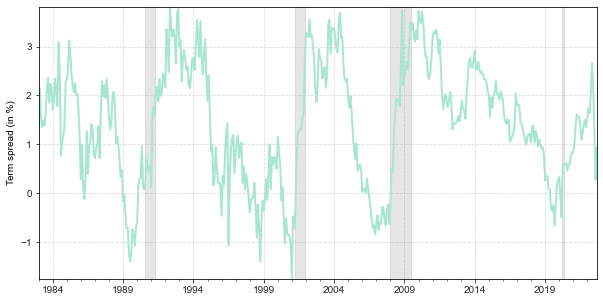

In [5]:
nber_recessions = df_data_monthly['USREC'].dropna()

# get start and end dates of recessions
change_nber = nber_recessions - nber_recessions.shift(1)
start_dates = change_nber[change_nber==1.0].index.to_list()
end_dates = change_nber[change_nber==-1.0].index.to_list()

ax = df_data_monthly['T10YFF'].plot(figsize=(10,5));
ax.set_ylabel('Term spread (in %)');
ax.set_xlabel('');
for s, e in zip(start_dates, end_dates):
    ax.axvspan(s, e, color="grey", alpha=0.2)

__Question 2__

First, we implement the log-likelihood function 

In [6]:
"""
Log-likelihood function 
"""

def log_like_probit(beta, y, x, individual=False): 
    
    pi = x @ beta
    prob = stats.norm.cdf(pi)
    
    log_like = y * np.log(prob) + (1-y) * np.log(1 - prob)
    
    if individual: 
        return -log_like
    else:
        return -np.sum(log_like)

Next, we select the data which we want to use

In [7]:
k = 6
y_data = df_data_monthly['USREC'].values[k:]
x_data = df_data_monthly['T10YFF'].values[:-k] / 100
x_data = np.c_[np.ones_like(x_data), x_data]

In [8]:
"""
Minimize negative log-likelihood 
"""
res = optimize.minimize(log_like_probit, [0.13,0.0], args=(y_data, x_data))
res

      fun: 113.1014390909346
 hess_inv: array([[ 1.19122179e-02, -4.71939402e-01],
       [-4.71939402e-01,  6.11924207e+01]])
      jac: array([3.81469727e-06, 0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 45
      nit: 14
     njev: 15
   status: 0
  success: True
        x: array([ -1.03667616, -38.831408  ])

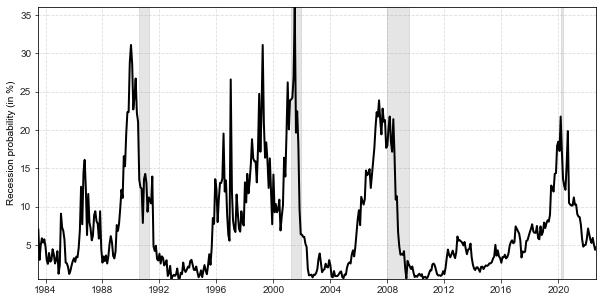

In [9]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(df_data_monthly['USREC'].index[k:].values, stats.norm.cdf(x_data @ res.x) * 100, color="black")

# get start and end dates of recessions
change_nber = nber_recessions - nber_recessions.shift(1)
start_dates = change_nber[change_nber==1.0].index.to_list()
end_dates = change_nber[change_nber==-1.0].index.to_list()

ax.set_ylabel('Recession probability (in %)');
ax.set_xlabel('');
for s, e in zip(start_dates, end_dates):
    ax.axvspan(s, e, color="grey", alpha=0.2)
    

__Question 3__

We note that 

$$
q_t(y_t, \mathbf{x}_t; \theta) = y_t \ln \Phi(\pi_{t}) + (1-y_t) \ln (1 - \Phi(\pi_{t}))
$$

First, we find the gradient (using the chain-rule, derivative of natural logarithm, fundamental theorem of calculus, etc.)

$$
\begin{align}
\frac{\partial q_t(y_t, \mathbf{x}_t; \theta)}{\partial \theta} &= \left[y_t \frac{1}{\Phi(\pi_{t})} - (1-y_t) \frac{1}{1 -\Phi(\pi_{t})} \right] \frac{\partial \Phi(\pi_{t})}{\partial \theta}\\
&= \left[y_t \frac{1}{\Phi(\pi_{t})} - (1-y_t) \frac{1}{1 -\Phi(\pi_{t})} \right] \phi(\pi_{t})\frac{\partial \pi_{t}}{\partial \theta} \\
&= \left[y_t \frac{1}{\Phi(\pi_{t})} - (1-y_t) \frac{1}{1 -\Phi(\pi_{t})} \right] \phi(\pi_{t})\mathbf{x}_t
\end{align}
$$

Implying that 

$$
\begin{align}
\frac{1}{n} \sum_{i=1}^n \frac{\partial q_t(y_t, \mathbf{x}_t; \theta)}{\partial \theta } \frac{\partial q_t(y_t, \mathbf{x}_t; \theta)}{\partial \theta^\top }  = \frac{1}{n} \sum_{i=1}^n \left[y_t \frac{1}{\Phi(\pi_{t})} - (1-y_t) \frac{1}{1 -\Phi(\pi_{t})} \right]^2 \phi(\pi_{t})^2\mathbf{x}_t\mathbf{x}_t^\top
\end{align}
$$

The Hessian is given by 

$$
\begin{align}
\frac{\partial^2 q_t(y_t, \mathbf{x}_t; \theta)}{\partial \theta \partial \theta^\top} &= \frac{\partial}{\partial \theta}\left[y_t \frac{1}{\Phi(\pi_{t})} - (1-y_t) \frac{1}{1 -\Phi(\pi_{t})} \right] \phi(\pi_{t})\mathbf{x}_t^\top \\
&= \left[\frac{\partial}{\partial \theta}\left[y_t \frac{1}{\Phi(\pi_{t})} - (1-y_t) \frac{1}{1 -\Phi(\pi_{t})} \right] \phi(\pi_{t})\mathbf{x}_t^\top \right] + \left[y_t \frac{1}{\Phi(\pi_{t})} - (1-y_t) \frac{1}{1 -\Phi(\pi_{t})} \right] \frac{\partial}{\partial \theta}\phi(\pi_{t})\mathbf{x}_t^\top \\
&=\left[-y_t \frac{1}{\Phi(\pi_{t})^2} - (1-y_t) \frac{1}{(1 -\Phi(\pi_{t}))^2} \right] \phi(\pi_{t})\mathbf{x}_t\phi(\pi_{t})\mathbf{x}_t^\top - \left[y_t \frac{1}{\Phi(\pi_{t})} - (1-y_t) \frac{1}{1 -\Phi(\pi_{t})} \right]  \phi(\pi_{t}) \mathbf{x}_t^\top \beta \mathbf{x}_t \mathbf{x}_t^\top \\
&=-\left[y_t \frac{\phi(\pi_{t}) + \mathbf{x}_t^\top \beta \Phi(\pi_{t})}{\Phi(\pi_{t})^2} + (1-y_t) \frac{\phi(\pi_{t}) - (1 -\Phi(\pi_{t}))\mathbf{x}_t^\top \beta}{(1 -\Phi(\pi_{t}))^2} \right] \phi(\pi_{t})\mathbf{x}_t\mathbf{x}_t^\top 
\end{align}
$$

Below, we implement the expressions. 

In [10]:
"""
Gradient (outer product of the scores)
"""

def outer_gradient(theta, x, y): 
    
    pi = x @ theta 
    pdf_vals = stats.norm.pdf(pi)
    cdf_vals = stats.norm.cdf(pi)
    
    first_part = (y * (1 / cdf_vals) - (1 - y) * (1 / (1-cdf_vals)))**2 * pdf_vals**2
    
    return np.sum(first_part[:, None, None] * np.einsum('ji,jk->jik',x, x), axis=0)
    

"""
Hessian 
"""

def hessian(theta, x, y): 
    
    pi = x @ theta 
    pdf_vals = stats.norm.pdf(pi)
    cdf_vals = stats.norm.cdf(pi)
    
    first_part = (-(y * (pdf_vals + pi * cdf_vals) / (cdf_vals**2) + 
                   (1 - y) * (pdf_vals - pi * (1 - cdf_vals)) / ((1-cdf_vals)**2)) * pdf_vals)
    
    return np.sum(first_part[:, None, None] * np.einsum('ji,jk->jik',x, x), axis=0)

__Question 5__

In [11]:
params_mle = res.x
A = hessian(params_mle, x_data, y_data)
B = outer_gradient(params_mle, x_data, y_data)

param_mle_cov_A = np.linalg.inv(-A)

param_mle_cov_B = np.linalg.inv(B)

param_mle_cov_sandwich = np.linalg.inv(A) @ B @ np.linalg.inv(A)

In [12]:
# covariance matrix based on A
param_mle_cov_A

array([[ 1.19123820e-02, -4.71382832e-01],
       [-4.71382832e-01,  6.14256874e+01]])

In [13]:
# covariance matrix based on B
param_mle_cov_B

array([[ 1.16843787e-02, -4.04935016e-01],
       [-4.04935016e-01,  4.83779523e+01]])

In [14]:
# covariance matrix based on A^{-1}BA^{-1} "Sandwich formula"
param_mle_cov_sandwich

array([[ 1.22446365e-02, -5.57443839e-01],
       [-5.57443839e-01,  7.82129256e+01]])

In [15]:
# sandwich standard errors 
np.sqrt(np.diag(param_mle_cov_sandwich))

array([0.11065549, 8.84380719])

In [16]:
"""
Numerical scores
"""

scores = approx_fprime(params_mle, log_like_probit, args=(y_data, x_data, True))
B_approx = scores.T @ scores 

A_approx = -approx_hess(params_mle, log_like_probit, args=(y_data, x_data))

param_mle_cov_A_num = np.linalg.inv(-A_approx)

param_mle_cov_B_num = np.linalg.inv(B_approx)

param_mle_cov_sandwich_num = np.linalg.inv(A_approx) @ B_approx @ np.linalg.inv(A_approx)

In [17]:
# covariance matrix based on A
param_mle_cov_A_num

array([[ 1.19123822e-02, -4.71382847e-01],
       [-4.71382847e-01,  6.14256885e+01]])

In [18]:
# covariance matrix based on B
param_mle_cov_B_num

array([[ 1.16843787e-02, -4.04935019e-01],
       [-4.04935019e-01,  4.83779518e+01]])

In [19]:
# covariance matrix based on A^{-1}BA^{-1} "Sandwich formula"
param_mle_cov_sandwich_num

array([[ 1.22446368e-02, -5.57443872e-01],
       [-5.57443872e-01,  7.82129293e+01]])

In [20]:
# sandwich standard errors 
np.sqrt(np.diag(param_mle_cov_sandwich_num))

array([0.11065549, 8.8438074 ])

__Question 6__

Yes, both the constant and the term spread is highly signficant. 

Luckily, we get the same results as `statsmodels`. 

In [21]:
import statsmodels.api as sm

stat_est = sm.Probit(y_data, x_data).fit(cov_type='HC0')
stat_est.summary()

Optimization terminated successfully.
         Current function value: 0.240130
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  471
Model:                         Probit   Df Residuals:                      469
Method:                           MLE   Df Model:                            1
Date:                Mon, 24 Oct 2022   Pseudo R-squ.:                  0.1105
Time:                        20:02:06   Log-Likelihood:                -113.10
converged:                       True   LL-Null:                       -127.16
Covariance Type:                  HC0   LLR p-value:                 1.147e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0367      0.111     -9.369      0.000      -1.254      -0.820
x1           -38.8314      8.844     -4.391      0.000     -56.165     -21.498
==============================================================================
"""

__Question 6__

In [22]:
x_dynamic_data = np.c_[x_data, df_data_monthly['USREC'].values[k-1:-1]]

In [23]:
res_dynamic = optimize.minimize(log_like_probit, [0.0,0.0, 0.0], args=(y_data, x_dynamic_data))
res_dynamic

      fun: 30.05149986288398
 hess_inv: array([[ 4.42499673e-02, -3.76302332e-01, -4.00199434e-02],
       [-3.76302332e-01,  2.84543883e+02, -2.80570544e+00],
       [-4.00199434e-02, -2.80570544e+00,  1.57366259e-01]])
      jac: array([-2.38418579e-06, -2.38418579e-07,  6.19888306e-06])
  message: 'Optimization terminated successfully.'
     nfev: 104
      nit: 22
     njev: 26
   status: 0
  success: True
        x: array([ -2.03752538, -47.31034878,   3.66989173])

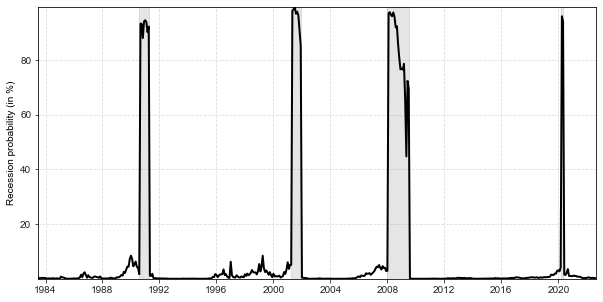

In [24]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(df_data_monthly['USREC'].index[k:].values, stats.norm.cdf(x_dynamic_data @ res_dynamic.x) * 100, color="black")

# get start and end dates of recessions
change_nber = nber_recessions - nber_recessions.shift(1)
start_dates = change_nber[change_nber==1.0].index.to_list()
end_dates = change_nber[change_nber==-1.0].index.to_list()

ax.set_ylabel('Recession probability (in %)');
ax.set_xlabel('');
for s, e in zip(start_dates, end_dates):
    ax.axvspan(s, e, color="grey", alpha=0.2)
    

__Question 7__

In [25]:
"""
Log-likelihood function 
"""

def calculate_recession_probs(theta, x): 
    
    beta = theta[:-1]
    alpha = theta[-1]
    
    pi = x @ beta
    for i in range(1, len(x)):
        pi[i] += alpha * pi[i-1]
        
    prob = stats.norm.cdf(pi)
    return prob

def log_like_autoregressiv_probit(theta, y, x, individual=False): 
        
    prob = calculate_recession_probs(theta, x)
    
    log_like = y * np.log(prob) + (1-y) * np.log(1 - prob)
    
    if individual: 
        return -log_like
    else:
        return -np.sum(log_like)
    

In [26]:
theta_init = [ -1.03667616, -4.831408, 0.7]
res_auto = optimize.minimize(log_like_autoregressiv_probit, theta_init,
                             args=(y_data, x_data),
                             method='L-BFGS-B',
                             #approx_grad=True,
                             #options={'eps': 1e-06,
                             #        'maxls':10},
                             options= {"gtol": 1e-6, "ftol": 1e-16, "maxfun": 30000, "maxiter": 30000, "maxls": 40},
                             bounds = ((None, None), (None, None),(0.0, 0.95)))
res_auto

      fun: 72.33733972379972
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.84217094e-06,  0.00000000e+00, -5.68434186e-06])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 212
      nit: 36
     njev: 53
   status: 0
  success: True
        x: array([ 5.47685730e-03, -1.46380073e+01,  9.36219755e-01])

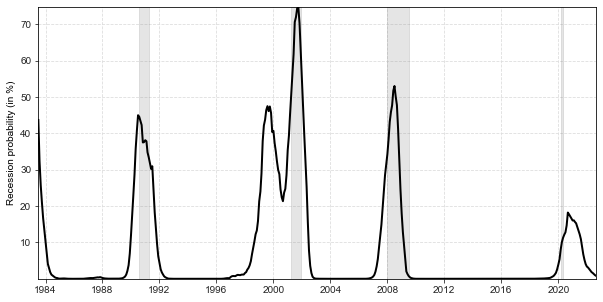

In [27]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(df_data_monthly['USREC'].index[k:].values, calculate_recession_probs(res_auto.x, x_data) * 100, color="black")

# get start and end dates of recessions
change_nber = nber_recessions - nber_recessions.shift(1)
start_dates = change_nber[change_nber==1.0].index.to_list()
end_dates = change_nber[change_nber==-1.0].index.to_list()

ax.set_ylabel('Recession probability (in %)');
ax.set_xlabel('');
for s, e in zip(start_dates, end_dates):
    ax.axvspan(s, e, color="grey", alpha=0.2)

## Problem 2: MLE and hypothesis testing 

Consider the [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) 

$$
f_{y}(y; \theta) = \frac{\beta^\rho}{\Gamma(\rho)} y^{\rho -1} e^{-y \beta}
$$
where $\theta = (\beta, \rho)^\top$, $\Gamma(\rho)$ is the [gamma function](https://en.wikipedia.org/wiki/Gamma_function). 

__Question 1__

Simulate 1,000 observations assuming $\beta = 1$ and $\rho=1$ from a gamma distribution. Plot the histogram together with the true density. 

__Question 2__

Define the log-likelihood function and estimate the parameters. Note that the functions `scipy.special.gamma`, `scipy.special.gammaln`, and `scipy.special.digamma` ([digamma function](https://en.wikipedia.org/wiki/Digamma_function)) may be relevant. 

__Question 3__

The gradiant is given by 

$$
\frac{\partial q_i(y_i ;\theta)}{\partial \theta } = \begin{bmatrix} \rho \frac{1}{\beta} - y_i \\ \ln \beta - \frac{\partial \ln \Gamma (\rho)}{\partial \rho} + \ln y_i\end{bmatrix}\\
$$

and therefore

$$
\frac{\partial q_i(y_i ;\theta)}{\partial \theta } \frac{\partial q_i(y_i ;\theta)}{\partial \theta^\top } = \begin{bmatrix} \rho \frac{1}{\beta} - y_i \\ \ln \beta - \frac{\partial \ln \Gamma (\rho)}{\partial \rho} + \ln y_i\end{bmatrix}\begin{bmatrix} \rho \frac{1}{\beta} - y_i \\ \ln \beta - \frac{\partial \ln \Gamma (\rho)}{\partial \rho} + \ln y_i\end{bmatrix}^\top = \begin{bmatrix} (\rho \frac{1}{\beta} - y_i)^2 & (\rho \frac{1}{\beta} - y_i) (\ln \beta - \frac{\partial \ln \Gamma (\rho)}{\partial \rho} + \ln y_i) \\
(\rho \frac{1}{\beta} - y_i) (\ln \beta - \frac{d \ln \Gamma (\rho)}{d \rho} + \ln y_i) & (\ln \beta - \frac{\partial \ln \Gamma (\rho)}{\partial \rho} + \ln y_i)^2 \end{bmatrix}
$$

and the Hessian is given by 

$$
\frac{\partial^2 q_i(y_i ;\theta)}{\partial \theta \partial \theta^\top } = \begin{bmatrix} \frac{-\rho}{\beta^2}  & \frac{1}{\beta} \\
\frac{1}{\beta} & - \frac{d^2 \ln \Gamma (\rho)}{d \rho^2} \end{bmatrix}
$$

Define a function that returns 

$$
\sum_{i=1}^n\frac{\partial^2 q_i(y_i ;\theta)}{\partial \theta \partial \theta^\top} = \sum_{i=1}^n \text{E} \left[ \frac{\partial^2 q_i(y_i ;\theta)}{\partial \theta \partial \theta^\top} \right] = \sum_{i=1}^n \begin{bmatrix} \frac{-\rho}{\beta^2}  & \frac{1}{\beta} \\
\frac{1}{\beta} & - \frac{d \ln \Gamma (\rho)}{d \rho^2} \end{bmatrix}
$$


__Question 4__

We remember that 

$$
\hat{\theta}_{MLE} \sim^a N\left(\theta_0, -\left[ \sum_{i=1}^n \text{E} \left[ \left. \frac{\partial^2 q_i(y_i ;\theta)}{\partial \theta \partial \theta^\top} \right \vert_{\theta = \theta_0}\right] \right]^{-1}\right)
$$

Since $\theta_0$ (in real life) is unkown, then we replace it with the obtained estimate. Calculate the standard errors of the estimator.

__Question 5__

The MLE follows a multivariate normal distribution in the limit (for simplicity let $\mathbf{V}$ denote the asymptotic variance)

$$
\hat{\theta} \sim^a N(\theta_0, \mathbf{V})
$$

If we let $\mathbf{R}$ be a $(q \times k)$ matrix and $\mathbf{r}$ be a $q \times 1$ vector where $q$ is the number of restrictions and $k$ is the number of parameters (so 2 in the model we are considering here). 

Assuming the null hypothesis 

$$
\text{H}_0 : \mathbf{R} \theta - \mathbf{r} = \mathbf{0}
$$

we will have (under the null hypothesis)

$$
\mathbf{R} \hat{\theta} - \mathbf{r} \sim^a N(\mathbf{0}, \mathbf{R}\mathbf{V}\mathbf{R}^\top)
$$

When testing a single hypothesis ($q=1$), we will have 

$$
\frac{\mathbf{R} \hat{\theta} - \mathbf{r}}{\sqrt{\mathbf{R}\mathbf{V}\mathbf{R}^\top}} \sim^a N(0, 1)
$$

If we want to test the hypothesis $\text{H}_0: \beta=1$ vs. the alternative $\text{H}_A: \beta \neq 1$ in the model considered here, we simple choose $\mathbf{R} = [0, 1]$ and $\mathbf{r} = 1$ such that 

$$
Z = \frac{\mathbf{R} \hat{\theta} - \mathbf{r}}{\sqrt{\mathbf{R}\mathbf{V}\mathbf{R}^\top}} = \frac{\hat{\beta} -  1}{\sqrt{V_{11}}} = \frac{\hat{\beta} -  1}{\sqrt{\text{Var}(\hat{\beta})}}  \sim^a N(0, 1)
$$

which is the well-known test statistic. We obtain the (two-side) $p$-value as $2 (1 - \Phi(\vert z \vert))$. 

Test the hypotheses that (one at the time) that $\beta=1$ and $\rho=1$. 


__Question 6__

We now want to test the joint hypothesis $\text{H}_0: \beta=1, \rho=1$ vs. the alternative $\text{H}_A: \beta \neq 1, \rho \neq 1$. 

To test this hypothesis, we have different possibilities:

* The likelihood ratio test
* The Wald test
* The Lagrange multiplier test

__The likelihood ratio test__

The basic idea is that we have some valid restrictions, say $\mathbf{c}(\theta) = \mathbf{r}$, then imposing it should not lead to a large reduction in the log-likelihood function. It is possible to show that the Likehood Ratio (LR) test statistic 

$$
LR = - 2 (\ln L_n^R - \ln L_n^U) \sim \chi^2 (q)
$$

follows a chi-squared distribution with degrees of freedom equal to the number of restrictions, $q$. $L_n^R$ is the restricted likelihood function and $L_n^U$ is the unrestricted likelihood function. 

__The Wald test__

If the restrictions are valid, then $\mathbf{c}(\hat{\theta}) - \mathbf{r}$ should be close to zero since the MLE is consistent. The wald test is based on $\mathbf{c}(\hat{\theta}) - \mathbf{r}$ and we will reject the hypothesis if this value is significantly different from zero. The wald test statistc can be written as 

$$
W = [\mathbf{c}\left(\hat{\theta}\right) - \mathbf{r}]^\top \left(\mathbf{C} \mathbf{V} \mathbf{C}^\top \right)^{-1} [\mathbf{c}\left(\hat{\theta}\right) - \mathbf{r}] \sim \chi^2 (q)
$$
where $\mathbf{C} = \left. \frac{\partial \mathbf{c}(\theta)}{\partial \theta^\top} \right \vert_{\theta=\hat{\theta}}$.  For linear restrictions $\mathbf{R} \theta - \mathbf{r}$, we will have

$$
W = [\mathbf{R} \hat{\theta} - \mathbf{r}]^\top \left(\mathbf{R} \mathbf{V} \mathbf{R}^\top \right)^{-1} [\mathbf{R} \hat{\theta} - \mathbf{r}] \sim \chi^2 (q)
$$

__The Lagrange multiplier test__

As the name entails, the test is related to the Lagrangian of the constrained problem 

$$
\mathcal{L}^*_n(\theta) = \mathcal{L}_n (\theta) + \lambda^\top (\mathbf{c}(\theta) - \mathbf{r}) 
$$

The solution to this constrained problem satisfies the the first order conditions 

$$
\begin{align}
\frac{\partial \mathcal{L}_n^* (\theta)}{\partial \theta}&=\frac{\partial \mathcal{L}_n (\theta)}{\partial \theta} + \mathbf{C}^\top \lambda = \mathbf{0}\\
\frac{\partial \mathcal{L}_n^* (\theta)}{\partial \lambda}&= \mathbf{c}(\theta) - \mathbf{r} = \mathbf{0}
\end{align}
$$

The restrictions not being binding corresponds to $\lambda = \mathbf{0}$ why we may define the null hypothesis as $\text{H}_0: \lambda= \mathbf{0}$ (i.e. the lagrange multiplier being equal to zero). A more common approach is obtained by noting that evaluated at the restricted estimate, then the score should be close to zero

$$
\hat{\mathbf{g}}_R = \left. \frac{\partial \mathcal{L}_n (\theta)}{\partial \theta} \right \vert_{\theta = \hat{\theta}_R} = \hat{\mathbf{C}}^\top \lambda = \mathbf{0}
$$

Under the nulll hypothesis the Lagrange Multiplier test statistic

$$
\left[\left. \frac{\partial \mathcal{L}_n (\theta)}{\partial \theta} \right \vert_{\theta = \hat{\theta}_R}  \right]^\top    \mathbf{V}_R \left[ \left. \frac{\partial \mathcal{L}_n (\theta)}{\partial \theta} \right \vert_{\theta = \hat{\theta}_R} \right] \sim \chi^2 (q)
$$

where $\mathbf{V}_R $ is the asymptotic variance of the restricted model. One advantage of the LM test is that we only need to estimate the model under the null hypothesis!

Implement all the three above tests. 

__Question 7__


[_Size_](https://en.wikipedia.org/wiki/Size_(statistics)) and [_power_](https://en.wikipedia.org/wiki/Power_of_a_test) are two key properties of a test.  Size is the probability of commiting a type I error, i.e. rejecting a true null hypothesis and power is the probability of rejecting a false null hypothesis. 

The distributions used above for testing hypotheses about the parameters rely on asymptotic theory, but this may be a bad approximation in small samples.

For different sample sizes, e.g. 100, 250, 500, 1000, using at least 10,000 simulated samples check how well the LR test statistic from a above follows a $\chi^2(q)$ distribution. 

__Question 8__

How often does the LR-statistic exceed the 5\% critical value for each of the sample sizes? 

__Question 9__

We want to examine the power of the LR test. To calculate the probability of rejecting the null hypothesis (we keep the one from above) given that it is false, then we need to assume some true alternative. We will assume that $\beta=1.25$. Redo the simulation and calculate how many times LR-statistic exceed the 5\% critical value for each of the sample sizes. 




### Solution 

__Question 1__

In [28]:
n = 1000
beta_true = 1.0
rho_true = 1.0
y_data = stats.gamma.rvs(a=rho_true, scale=1.0/beta_true, size=n)

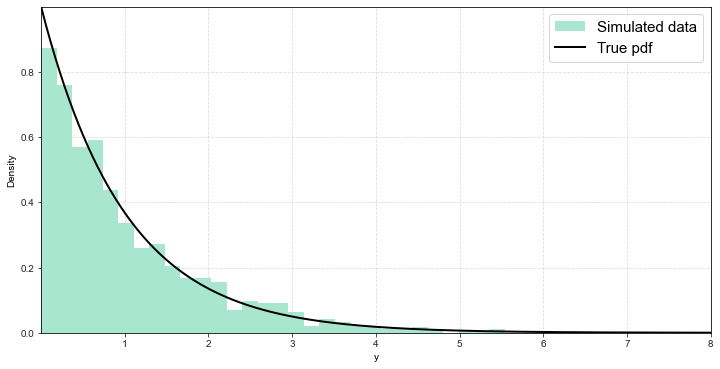

In [29]:
# density
y_vals = np.linspace(0.001, 8.0, 1000)
pdf_vals = stats.gamma.pdf(y_vals, a=rho_true, scale=1.0/beta_true)

# plotting 
fig, ax = plt.subplots(figsize=(12,6))

ax.hist(y_data, bins=30, density=True, label="Simulated data")
ax.plot(y_vals, pdf_vals, color="black", label="True pdf")

ax.set_xlabel("y")
ax.set_ylabel("Density")
ax.legend();

__Question 2__

The likelihood function can be written as 

$$
L_n(\theta) = \prod_{i=1}^n \frac{\beta^\rho}{\Gamma(\rho)} y_i^{\rho -1} e^{-y_i \beta}
$$

Taking the natural logarithm yields

$$
\mathcal{L}_{n}(\theta) = \sum_{i=1}^n q_i(y_i; \theta) = \sum_{i=1}^n \left[\rho \ln \beta - \ln \Gamma (\rho) + (\rho - 1) \ln y_i - y_i \beta \right] = n \left[\rho \ln \beta - \ln \Gamma (\rho) \right] + \sum_{i=1}^n \left[(\rho - 1) \ln y_i - y_i \beta \right]
$$



In [30]:
from scipy.special import gamma, gammaln, psi, polygamma

"""
Define log-likelihood 
"""

def log_like_gamma(theta, y,  individual=False):
    
    beta = theta[0]
    rho = theta[1]
    
    log_like = rho * np.log(beta) - gammaln(rho) + (rho - 1) * np.log(y) - y * beta
    
    if individual: 
        return -log_like
    else:
        return -np.sum(log_like)
    

"""
Minimize negative log-like 
"""
res = optimize.minimize(log_like_gamma, [1.0, 1.0], args=(y_data, ))
params_mle = res.x

__Question 3__


In [31]:
def gamma_log_like_hessian(theta: np.array, y: np.array):
    
    """
    Calculates the Hessian of the log-likelihood function 
    """
    
    beta = theta[0]
    rho = theta[1]
    n = len(y)
    
    hess = np.array([[-rho / (beta**2), 1.0 / beta], [1.0 / beta, - polygamma(1, rho)]])
    
    return n * hess

__Question 4__



In [32]:
A = gamma_log_like_hessian(params_mle, y_data)
V = -np.linalg.inv(A)
np.sqrt(np.diag(V))

array([0.05143286, 0.04137149])

__Question 5__

In [33]:
"""
Testing beta=1
"""

z_beta = (params_mle[0] - 1.0) / np.sqrt(V[0,0])

p_value_beta =  2.0*(1.0 - stats.norm.cdf(np.abs(z_beta)))
p_value_beta

0.6289240162648881

In [34]:
"""
Testing rho=1
"""

z_rho = (params_mle[1] - 1.0) / np.sqrt(V[1,1])

p_value_rho =  2.0*(1.0 - stats.norm.cdf(np.abs(z_rho)))
p_value_rho

0.26141622527037844

__Quesiton 6__



In [35]:
"""
LR test
"""

like_ratio = 2 * (log_like_gamma([1.0, 1.0], y_data) - 
                  log_like_gamma(params_mle, y_data))

p_val_lr = 1 - stats.chi2.cdf(like_ratio, 2)

print("LR: " + str(like_ratio))
print("p-value: " + str(p_val_lr))

LR: 1.7417052380931182
p-value: 0.418594495414245


In [36]:
"""
Wald test
"""
R = np.eye(2)
r = np.ones(2)
constraint = (R @ params_mle - r)
cov_inv = np.linalg.inv(R @ V @ R.T)

wald = constraint.T @ cov_inv @ constraint
p_val_wald = 1 - stats.chi2.cdf(wald, 2)

print("Wald: " + str(wald))
print("p-value: " + str(p_val_wald))

Wald: 1.6860279775938753
p-value: 0.4304113116363554


In [54]:
"""
Lagrange Multiplier test
"""

# get covariance matrix of restricted modle 
A_res = gamma_log_like_hessian([1.0, 1.0], y_data)
V_res = -np.linalg.inv(A_res)
np.sqrt(np.diag(V))

# define a function calculating the score (we could also do this numerically)
def gamma_log_like_score(theta: np.array, y: np.array, individual=False):
    
    """
    Calculates the score of the log-likelihood function 
    """
    
    beta = theta[0]
    rho = theta[1]
    n = len(y)
    
    score_beta = rho / beta - y
    score_rho = np.log(rho) -  polygamma(0, rho) + np.log(y)
    score = np.column_stack((score_beta, score_rho))
    
    if individual:
        
        return score
    
    else: 
    
        return np.sum(score, axis=0)
    
# calculate score
score_restricted = gamma_log_like_score([1.0, 1.0], y_data, individual=False)

# LM stat
lm = score_restricted.T @ V_res @ score_restricted

p_val_lm = 1 - stats.chi2.cdf(lm, 2)

print("LM: " + str(lm))
print("p-value: " + str(p_val_lm))

LM: 1.8673474855503378
p-value: 0.39310688079580514


In [55]:
gamma_log_like_score([1.0, 1.0], y_data, individual=True)

array([[-6.64368137e-01,  1.08666122e+00],
       [-1.46725232e-01,  7.14125921e-01],
       [ 6.35227437e-01, -4.31265569e-01],
       [ 5.70931881e-01, -2.68923923e-01],
       [ 7.81628848e-01, -9.44343467e-01],
       [ 3.37121301e-01,  1.66052402e-01],
       [ 7.03936873e-01, -6.39966916e-01],
       [-5.86331133e-01,  1.03863955e+00],
       [-5.60355240e-01,  1.02212918e+00],
       [ 8.94645295e-01, -1.67320682e+00],
       [ 9.76704365e-01, -3.18227362e+00],
       [ 6.17198838e-01, -3.83023918e-01],
       [-2.42255145e-01,  7.94144058e-01],
       [-1.83390363e-02,  5.95388569e-01],
       [ 6.24503272e-01, -4.02289858e-01],
       [ 3.57286509e-01,  1.35159429e-01],
       [ 8.31668046e-01, -1.20460167e+00],
       [-1.97263339e+00,  1.66666389e+00],
       [ 4.36217675e-01,  4.12861453e-03],
       [-4.75439317e-01,  9.66171452e-01],
       [ 7.61168597e-01, -8.54781738e-01],
       [ 1.32261586e-01,  4.35350689e-01],
       [ 2.30870058e-01,  3.14720316e-01],
       [ 7.

In [57]:
# the numerical derivative will have a different sign since we have defined the negative log-likelihood
approx_fprime(np.array([1.0, 1.0]), log_like_gamma, args=(y_data, True))

array([[ 6.64368138e-01, -1.08666120e+00],
       [ 1.46725237e-01, -7.14125901e-01],
       [-6.35227431e-01,  4.31265581e-01],
       [-5.70931874e-01,  2.68923935e-01],
       [-7.81628840e-01,  9.44343479e-01],
       [-3.37121293e-01, -1.66052394e-01],
       [-7.03936867e-01,  6.39966927e-01],
       [ 5.86331129e-01, -1.03863955e+00],
       [ 5.60355246e-01, -1.02212916e+00],
       [-8.94645288e-01,  1.67320683e+00],
       [-9.76704358e-01,  3.18227363e+00],
       [-6.17198829e-01,  3.83023929e-01],
       [ 2.42255151e-01, -7.94144049e-01],
       [ 1.83390379e-02, -5.95388561e-01],
       [-6.24503266e-01,  4.02289871e-01],
       [-3.57286498e-01, -1.35159418e-01],
       [-8.31668038e-01,  1.20460168e+00],
       [ 1.97263339e+00, -1.66666389e+00],
       [-4.36217666e-01, -4.12860513e-03],
       [ 4.75439310e-01, -9.66171443e-01],
       [-7.61168590e-01,  8.54781751e-01],
       [-1.32261582e-01, -4.35350679e-01],
       [-2.30870053e-01, -3.14720303e-01],
       [-7.

__Question 7__

First, we simulate all the data that we need to use.

In [40]:
n = 500
num_sim = 10000
beta_true = 1.0
rho_true = 1.0
y_data_all = stats.gamma.rvs(a=rho_true, scale=1.0/beta_true, size=(num_sim, n))

In [41]:
sample_sizes = [25, 50, 100, 500]
output_lr = np.empty((num_sim, len(sample_sizes)))

for j, sample_size in enumerate(sample_sizes):
    for i in range(num_sim):
        
        # select data
        y_data = y_data_all[i, :sample_size]

        # estimate 
        res = optimize.minimize(log_like_gamma, [1.0, 1.0], args=(y_data,),
                                bounds=((0.001, None), (0.001, None)))
        # calculate LR statistics 
        output_lr[i, j] = 2 * (log_like_gamma([1.0, 1.0], y_data) - log_like_gamma(res.x, y_data))


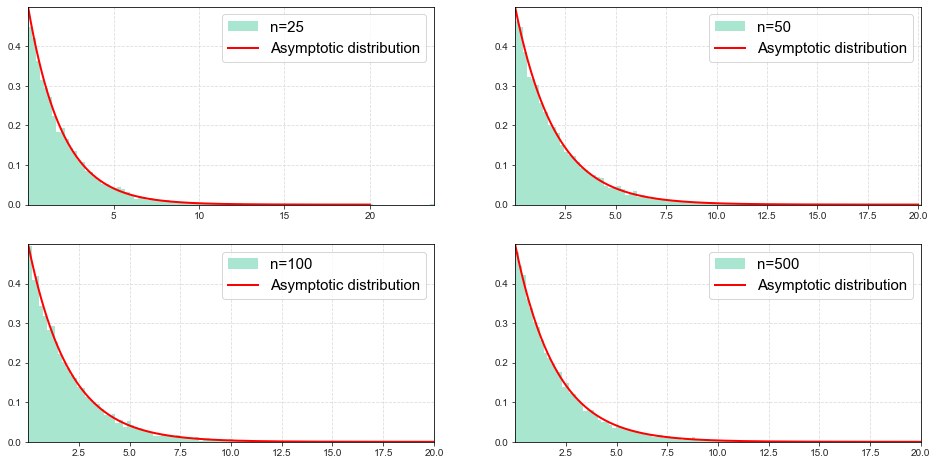

In [42]:
"""
Histogram and chi^2(2)
"""
x_values = np.linspace(0.001, 20, 1000)
chi_pdf_values = stats.chi2.pdf(x_values, 2)

fig, ax = plt.subplots(2, 2, figsize=(16, 8))
ax = ax.flatten()
for i in range(len(sample_sizes)):
    ax[i].hist(output_lr[:, i], bins=100, density=True, label="n={}".format(sample_sizes[i]), alpha=1.0); 
    ax[i].plot(x_values, chi_pdf_values, color="red", label="Asymptotic distribution")
    ax[i].legend();


__Question 8__

The test seems to be well sized in the sense that the proportion of rejection the null hypothesis is close to the significance level. 

In [43]:
np.sum(output_lr>stats.chi2.ppf(0.95, 2), axis=0) / num_sim 

array([0.0518, 0.05  , 0.0484, 0.0499])

__Questio 9__

Naturally, the power is increasing with the sample size!

In [44]:
n = 500
num_sim = 10000
beta_true = 1.25
rho_true = 1.0
y_data_all = stats.gamma.rvs(a=rho_true, scale=1.0/beta_true, size=(num_sim, n))

In [45]:
sample_sizes = [25, 50, 100, 500]
output_power_lr = np.empty((num_sim, len(sample_sizes)))

for j, sample_size in enumerate(sample_sizes):
    for i in range(num_sim):
        
        # select data
        y_data = y_data_all[i, :sample_size]

        # estimate 
        res = optimize.minimize(log_like_gamma, [1.0, 1.0], args=(y_data,),
                                bounds=((0.001, None), (0.001, None)))
        # calculate LR statistics 
        output_power_lr[i, j] = 2 * (log_like_gamma([1.0, 1.0], y_data) - log_like_gamma(res.x, y_data))


In [46]:
np.sum(output_power_lr>stats.chi2.ppf(0.95, 2), axis=0) / num_sim 

array([0.1546, 0.2599, 0.4848, 0.9967])

### Statsmodels implementation

In [47]:
from statsmodels.base.model import GenericLikelihoodModel

class GammaLogLModel(GenericLikelihoodModel):
    
    nparams = 2
    
    def loglike(self, params):
        
        endog = self.endog
        
        beta = params[0]
        rho = params[1]
        
        return stats.gamma.logpdf(endog, rho, scale = 1.0 / beta).sum()


res = GammaLogLModel(y_data).fit(start_params=[1.0, 1.0])

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.939583
         Iterations: 27
         Function evaluations: 51
                            GammaLogLModel Results                            
Dep. Variable:                      y   Log-Likelihood:                -469.79
Model:                 GammaLogLModel   AIC:                               nan
Method:            Maximum Likelihood   BIC:                               nan
Date:                Mon, 24 Oct 2022                                         
Time:                        20:04:47                                         
No. Observations:                 500                                         
Df Residuals:                     NaN                                         
Df Model:                         NaN                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

C:\environments\python_for_fin_econ\lib\site-packages\statsmodels\base\model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")
C:\environments\python_for_fin_econ\lib\site-packages\statsmodels\base\model.py:2696: UserWarning: df_resid differs from nobs - nparams
  warnings.warn("df_resid differs from nobs - nparams")


__Question 5__

In [48]:
res.t_test('par0=1')

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             1.0894      0.078      1.153      0.249       0.937       1.241

In [49]:
res.t_test('par1=1')

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             1.0258      0.057      0.450      0.653       0.914       1.138

## Problem 3: Shrinkage estimators

Assume that $\mathbf{X} \sim N(\boldsymbol{\mu}, \boldsymbol{\Sigma})$ is multivariate normal. 

The [Mean-Squared-Error (MSE)](https://en.wikipedia.org/wiki/Mean_squared_error) of the sample mean can be written as 

$$
\text{MSE} \equiv \text{E}[\| \bar{\mathbf{X}} - \boldsymbol{\mu} \|^2] = \text{E}\left[\| \bar{\mathbf{X}} - \text{E}[\bar{\mathbf{X}}] \|^2 \right] + \left \|\text{E}[\bar{\mathbf{X}}] - \boldsymbol{\mu}\right \|^2 = \text{Var}[\bar{\mathbf{X}}] + \text{Bias}[\bar{\mathbf{X}}, \boldsymbol{\mu}]^2
$$

where $\| \cdot \|$ denotes the [norm](https://en.wikipedia.org/wiki/Norm_(mathematics)). Basically, this tells us that we can look at an estimator in relation to its bias and inefficiency (variance). 

In this exercise, we will see if we can find another estimator that performs better than the sample mean (in mean-square sense) 

$$
\bar{\mathbf{X}} = \frac{1}{n} \sum_{i=1}^n \mathbf{X}_i
$$

__Question 1__

Assume that 

$$
\boldsymbol{\mu} = \begin{bmatrix} 0.0 \\ 0.0 \\ 0.1 \\ -0.1 \\ 0.2 \end{bmatrix}
$$

and for $\theta \in (0, 1)$

$$
\boldsymbol{\Sigma} = \begin{bmatrix}
1 & \theta & \dots & \theta \\
\theta & 1 & \ddots & \vdots \\
\theta & \theta & \ddots & \theta \\
\theta & \theta & \dots & 1 \\
\end{bmatrix}
$$

We can think of $\theta$ as representing the overall correlation among the random variables. 

For $\theta \in [0.0, 0.1, 0.2, ... , 0.9, 0.99]$ simulate 100 observations 10,000 times. Calculate the simulated value of the MSE for each different value of $\theta$ (remember that we know the true value of $\boldsymbol{\mu}$). Plot a stacked bar plot with MSE divided into variance and bias. 


__Question 2__

[Attilio Meucci, "Risk and Asset Allocation"](https://www.amazon.com/Risk-Asset-Allocation-Springer-Finance/dp/3642009646) presents the [_James-Stein shrinkage estimator_](https://en.wikipedia.org/wiki/James%E2%80%93Stein_estimator) of the expected value

$$
\hat{\boldsymbol{\mu}} = (1-\alpha) \bar{\mathbf{X}} + \alpha \mathbf{b}
$$
where $\mathbf{b}$ is a constant vector. The optimal $\alpha$ is given by 

$$
\alpha = \frac{1}{n} \frac{m \bar{\lambda} - 2 \lambda_1}{(\bar{\mathbf{X}} -  \mathbf{b})^\top (\bar{\mathbf{X}} -  \mathbf{b})}
$$
where  $m$ is the number of variables,  $\bar{\lambda}$ and $\lambda_1$ are respectively the average value and largest value of the eigenvalues of $\boldsymbol{\Sigma}$. 

We choose to shrink towards the "grand-mean"

$$
\frac{\mathbf{1}^\top \bar{X}}{m} \mathbf{1}
$$

where $\mathbf{1}$ is a m-dimensional vector of ones. 

Implement the estimator and perform the same calculations as in the previous question. Can the shrinkage estimator perform better than the sample mean?


### Solution 

__Question 1__

In [50]:
num_var = 5
num_sim = 100000
num_obs = 100

theta_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
mu_values = np.array([0.0, 0.0, 0.1, -0.1, 0.2])

# standard normal random variables
random_draws = np.random.normal(size=(num_var, num_obs, num_sim))

all_mse = list()
all_bias = list() 
all_var = list()
for theta in theta_values: 
    
    # construct corr / covariance matrix
    corr = np.tile(theta, (num_var, num_var))
    np.fill_diagonal(corr, 1.0)
    
    # Use cholesky decomposition to normal random variables
    transformed_random_draws = mu_values[:, None, None] + np.einsum('ij,jlk->ilk',
                                                                    np.linalg.cholesky(corr), random_draws)
    
    # calculate average of all sample means
    expected_sample_mean = np.mean(np.mean(transformed_random_draws, axis=1), axis=1)
    
    # calculate the variance
    var =  np.mean(np.linalg.norm(np.mean(transformed_random_draws, axis=1) - 
                          expected_sample_mean[:, None], axis=0)**2)
    
    # calculate the bias squared
    bias = np.linalg.norm(expected_sample_mean - mu_values)**2
    
    # calculate the total MSE (should be equal to var + bias)
    mse = np.mean(np.linalg.norm(np.mean(transformed_random_draws, axis=1) - mu_values[:, None], axis=0)**2)
    # or just use np.trace(corr) / num_obs <- theoretical correct value
    
    all_mse.append(mse)
    all_bias.append(bias)
    all_var.append(var)
    
    

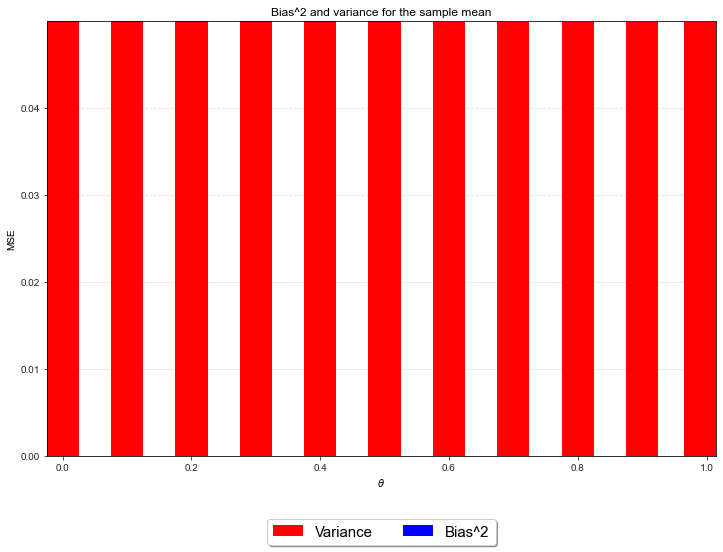

In [51]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(theta_values, all_var, width=0.05, label="Variance", color="red");
ax.bar(theta_values, all_bias, width=0.05, bottom=all_var, label="Bias^2", color="blue");
ax.set_ylabel('MSE')
ax.set_xlabel('$\\theta$')
ax.set_title("Bias^2 and variance for the sample mean")
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.175),
          fancybox=True, shadow=True, ncol=2);

The sample mean is an unbiased estimator so the only problem is coming from the variance. 

__Question 2__


We see that with limited correlation between the variables, then the shrinkage estimator lowers the total MSE. 

In [52]:
all_mse_shrink = list()
all_bias_shrink = list() 
all_var_shrink = list()
for theta in theta_values: 
    
    # construct corr / covariance matrix
    corr = np.tile(theta, (num_var, num_var))
    np.fill_diagonal(corr, 1.0)
    
    # Use cholesky decomposition to normal random variables
    transformed_random_draws = mu_values[:, None, None] + np.einsum('ij,jlk->ilk',
                                                                    np.linalg.cholesky(corr), random_draws)
    
    # average and maximum eigenvalue
    eig_vals = np.linalg.eigvals(corr)
    max_eig = max(eig_vals)
    avg_eig = np.mean(eig_vals)

    # get grand mean
    x_bar = np.mean(transformed_random_draws, axis=1)
    b = np.mean(x_bar, axis=0)
    b = np.tile(b, (num_var, 1))
    
    # calculate optimal alpha
    diff = x_bar - b
    denominator = np.einsum('ij,ij->j', diff, diff)

    alpha = (1.0 / num_obs) * (num_var * avg_eig - 2 * max_eig)  / denominator
    alpha = np.clip(alpha, 0, 1)
    alpha = np.tile(alpha, (num_var, 1))
    
    # shrinkage estimator
    mu_est = x_bar * (1 - alpha) + b * alpha

    # calculate average of all mean estimates
    expected_sample_mean = np.mean(mu_est, axis=1)
    
    # calculate the variance
    var =  np.mean(np.linalg.norm(mu_est - expected_sample_mean[:, None], axis=0)**2)
    
    # calculate bias squared
    bias = np.linalg.norm(expected_sample_mean - mu_values)**2
    
    # calculate the total MSE (should be equal to var + bias)
    mse = np.mean(np.linalg.norm(mu_est - mu_values[:, None], axis=0)**2)
    
    all_mse_shrink.append(mse)
    all_bias_shrink.append(bias)
    all_var_shrink.append(var)
    

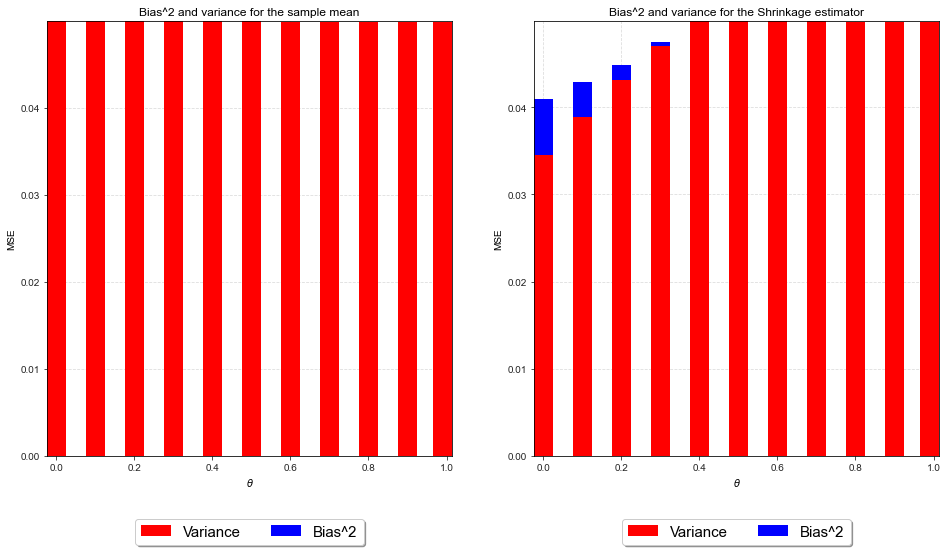

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))


ax[0].bar(theta_values, all_var, width=0.05, label="Variance", color="red");
ax[0].bar(theta_values, all_bias, width=0.05, bottom=all_var, label="Bias^2", color="blue");
ax[0].set_ylabel('MSE')
ax[0].set_xlabel('$\\theta$')
ax[0].set_title("Bias^2 and variance for the sample mean")
ax[0].legend(loc='center', bbox_to_anchor=(0.5, -0.175),
          fancybox=True, shadow=True, ncol=2);

ax[1].bar(theta_values, all_var_shrink, width=0.05, label="Variance", color="red");
ax[1].bar(theta_values, all_bias_shrink, width=0.05, bottom=all_var_shrink, label="Bias^2", color="blue");
ax[1].set_ylabel('MSE')
ax[1].set_xlabel('$\\theta$')
ax[1].set_title("Bias^2 and variance for the Shrinkage estimator")
ax[1].legend(loc='center', bbox_to_anchor=(0.5, -0.175),
          fancybox=True, shadow=True, ncol=2);

# References


## Articles



## Books

[Attilio Meucci, "Risk and Asset Allocation"](https://www.amazon.com/Risk-Asset-Allocation-Springer-Finance/dp/3642009646)